# Evaluation of CosmoFlow training

In [11]:
import os
import sys
import yaml

sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [3]:
from models import get_model
from data.cosmo import construct_dataset
from utils.optimizers import get_optimizer

In [4]:
%matplotlib inline

## Load configuration

In [5]:
def load_config(config_file):
    """Reads the YAML config file and returns a config dictionary"""
    with open(config_file) as f:
        return yaml.load(f, Loader=yaml.FullLoader)

In [6]:
config_file = '../configs/cosmo.yaml'

In [7]:
config = load_config(config_file)

In [8]:
config

{'output_dir': '$SCRATCH/cosmoflow-benchmark/cosmoflow-19-06-12',
 'data': {'name': 'cosmo',
  'data_dir': '/project/projectdirs/m3363/www/cosmoUniverse_2018_10_3parA/dim128_cube',
  'n_train_files': 2048,
  'n_valid_files': 1024,
  'samples_per_file': 16,
  'batch_size': 4,
  'n_epochs': 64},
 'model': {'name': 'cosmoflow',
  'input_shape': [128, 128, 128, 1],
  'target_size': 3,
  'dropout': 0.2},
 'optimizer': {'name': 'Adam', 'lr': 0.001},
 'train': {'loss': 'mse', 'metrics': ['mae']}}

## View training history

In [9]:
def load_history(result_dir):
    return pd.read_csv(os.path.join(result_dir, 'history.csv'))

In [10]:
ls /global/cscratch1/sd/sfarrell/cosmoflow-benchmark

cosmoflow-154846/  cosmoflow-156746/  cosmoflow-158215/    cosmoflow-19-06-12/
cosmoflow-154858/  cosmoflow-157761/  cosmoflow-158230/    cosmoflow-hvd/
cosmoflow-154996/  cosmoflow-158072/  cosmoflow-158235/    cosmoflow-test/
cosmoflow-155912/  cosmoflow-158127/  cosmoflow-158333/
cosmoflow-155987/  cosmoflow-158130/  cosmoflow-19-06-11/


In [12]:
result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/cosmoflow-19-06-12'

In [ ]:
ls -l $result_dir

In [14]:
train_history = load_history(result_dir)

In [15]:
train_history

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0,0.307745,0.437998,0.233117,0.395916
1,1,0.217761,0.381878,0.193098,0.358667
2,2,0.198378,0.361850,0.171115,0.331508
3,3,0.179857,0.340414,0.165824,0.326921
4,4,0.170125,0.328492,0.164715,0.324317
5,5,0.166678,0.324343,0.154609,0.312586
6,6,0.165961,0.323595,0.151002,0.307323
7,7,0.163636,0.320612,0.155234,0.315110
8,8,0.162490,0.319341,0.151845,0.307254
9,9,0.161006,0.317511,0.201811,0.360689


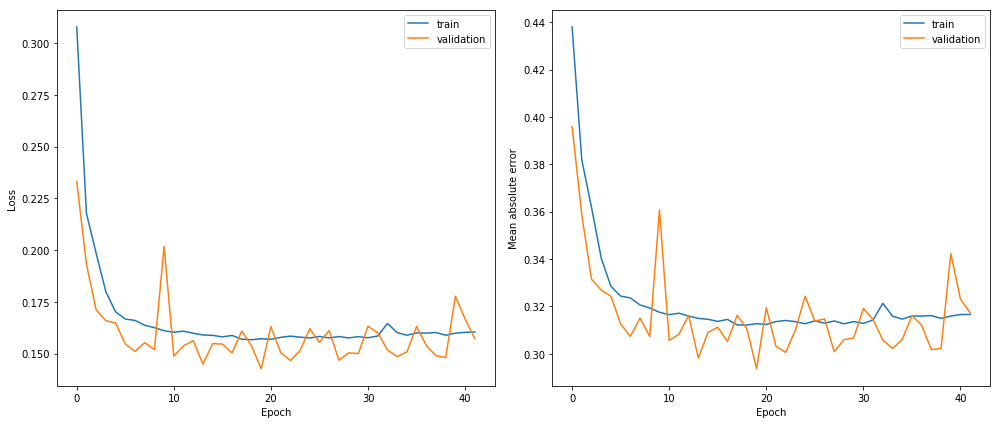

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.plot(train_history.loss, label='train')
ax0.plot(train_history.val_loss, label='validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(train_history.mean_absolute_error, label='train')
ax1.plot(train_history.val_mean_absolute_error, label='validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute error')
ax1.legend(loc=0)

plt.tight_layout()

## Reload the model

In [17]:
# Choose best epoch based on validation loss
best_epoch = train_history.epoch.loc[train_history.val_loss.idxmin()]
print('Best epoch:', best_epoch)

Best epoch: 19


In [18]:
# Load the model checkpoint
checkpoint = os.path.join(result_dir, 'checkpoint-{epoch:03d}.h5'.format(epoch=best_epoch))
model = tf.keras.models.load_model(checkpoint)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 128, 128, 128, 16) 448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 64, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 64, 16)    6928      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 32, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 32, 16)    6928      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 16, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 16, 16, 16)    6928      
__________

## Evaluate the model on a test set

In [26]:
def convert_data_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        converted_data = [sess.run(iter_next) for i in range(n_steps)]
        return map(np.concatenate, zip(*converted_data))

In [21]:
n_test_files = 8
data_config = config['data']
batch_size = data_config['batch_size']
data_dir = data_config['data_dir']
n_test = n_test_files * data_config['samples_per_file']
n_test_steps = n_test // batch_size

In [22]:
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
             if f.endswith('tfrecords')]
test_files = all_files[-n_test_files:]

In [23]:
# Construct the test dataset
test_data = construct_dataset(test_files, batch_size=batch_size, n_epochs=1)

In [24]:
# Apply the model to the test set
test_pred = model.predict(test_data, steps=n_test_steps, verbose=1)

32/32 [==============================] - 113s 4s/step


In [27]:
test_x, test_y = convert_data_to_np(test_data, n_test_steps)

In [28]:
test_x.shape, test_y.shape, test_pred.shape

((128, 128, 128, 128, 1), (128, 3), (128, 3))

## Model analysis

Let's make some detailed plots to understand the performance of the model

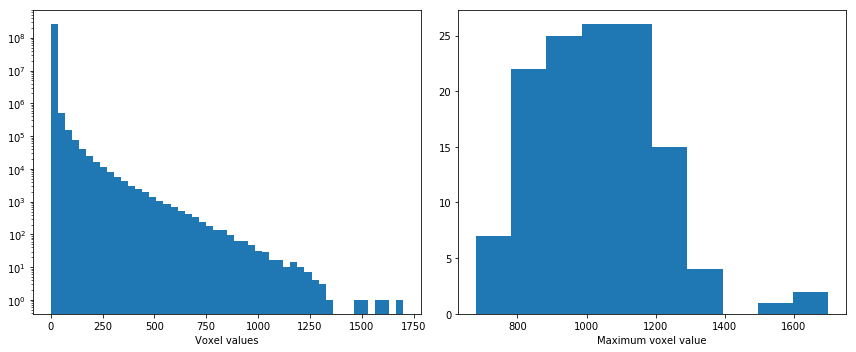

In [29]:
# Voxel value distributions
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

# Voxel value
ax0.hist(test_x.flatten(), log=True, bins=50)
ax0.set_xlabel('Voxel values')

# Maximum voxel value
ax1.hist(test_x.reshape(n_test, -1).max(axis=1))
ax1.set_xlabel('Maximum voxel value')

plt.tight_layout()

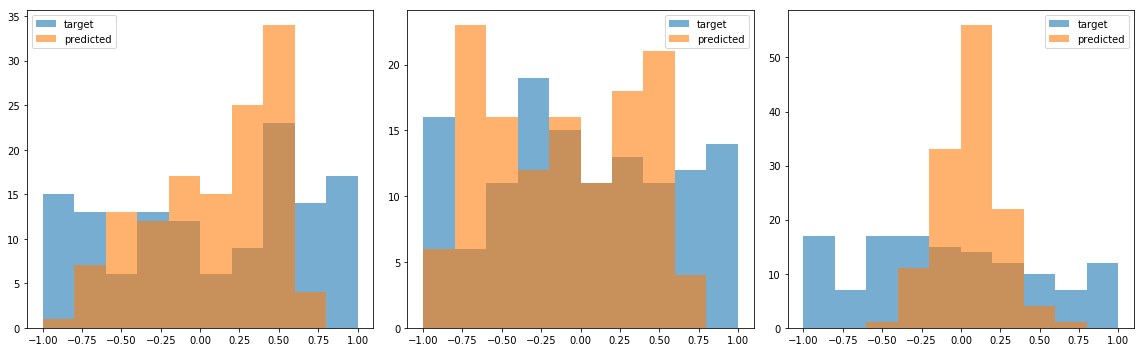

In [30]:
# 1D Distributions of cosmo params
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 5))

hist_args = dict(bins=10, range=(-1,1), alpha=0.6)
ax0.hist(test_y[:,0], label='target', **hist_args)
ax0.hist(test_pred[:,0], label='predicted', **hist_args)
ax0.legend(loc=0)
ax1.hist(test_y[:,1], label='target', **hist_args)
ax1.hist(test_pred[:,1], label='predicted', **hist_args)
ax1.legend(loc=0)
ax2.hist(test_y[:,2], label='target', **hist_args)
ax2.hist(test_pred[:,2], label='predicted', **hist_args)
ax2.legend(loc=0)

plt.tight_layout()

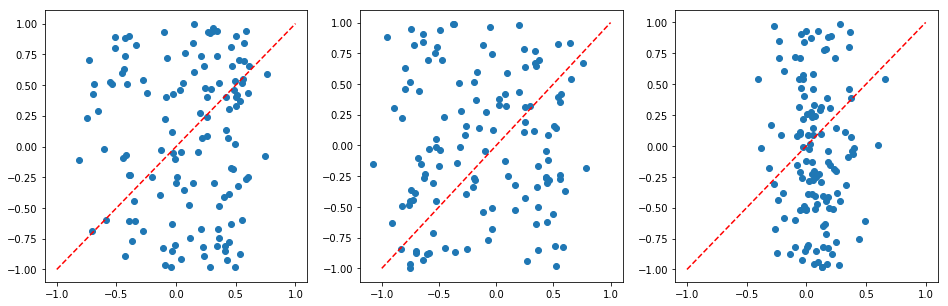

In [31]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 5))

ax0.scatter(test_pred[:,0], test_y[:,0])
ax0.plot([-1, 1], [-1, 1], 'r--')
ax1.scatter(test_pred[:,1], test_y[:,1])
ax1.plot([-1, 1], [-1, 1], 'r--')
ax2.scatter(test_pred[:,2], test_y[:,2])
ax2.plot([-1, 1], [-1, 1], 'r--')

## Discussion

This model is training, but not yet doing very well.